### Setup

In [100]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [101]:
# Check if Cuda is running
#torch.cuda.get_device_name(0)

In [102]:
data = pd.read_csv("creditcard.csv")

Let's randomize the data, just to be sure not to get any pathological ordering effects that might harm the performane of Stochastic Gradient Descent.

In [103]:
data = data.reindex(np.random.permutation(data.index))
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
182986,125610.0,2.034148,0.154161,-1.611659,1.400501,0.321203,-1.179898,0.557677,-0.349891,0.385929,...,0.033994,0.276646,0.015646,-0.041061,0.418213,-0.485054,-0.021966,-0.065202,5.30,0
96242,65682.0,-1.539670,-0.136292,-0.487530,-1.803377,-0.682149,5.002360,1.149282,1.006731,0.712523,...,0.059799,0.549998,-0.184689,1.092103,0.639722,-0.335996,0.138411,-0.186291,500.18,0
260420,159551.0,1.798197,0.031467,-2.354035,0.805700,0.695347,-0.820213,0.501518,-0.313056,0.644817,...,-0.097348,-0.218867,-0.028084,0.465756,0.203168,-0.334205,0.001463,0.022422,127.58,0
206893,136426.0,2.191200,-1.779188,-2.280609,-2.559004,1.041622,3.516327,-1.661236,0.824354,-1.334258,...,-0.168301,-0.172954,0.261576,0.682517,-0.215848,-0.185769,0.026945,-0.046755,59.99,0
243317,151883.0,2.351102,-1.281518,-1.326753,-1.746897,-0.671208,-0.177083,-1.013331,-0.192647,-1.319505,...,-0.205857,-0.052773,0.175353,0.028188,-0.043841,-0.150844,0.011251,-0.050236,15.38,0


In [104]:
data.ndim

2

### Data Analysis

In [105]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.190839e-15,3.401315e-16,-1.378713e-15,2.068822e-15,1.023753e-15,1.466459e-15,-5.848412e-16,1.419567e-16,-2.433713e-15,...,1.653784e-16,-3.200989e-16,2.696667e-16,4.471375e-15,5.208960e-16,1.681195e-15,-3.731738e-16,-1.226801e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [106]:
data.isnull().sum().sum()

0

Text(0,0.5,'Frequency')

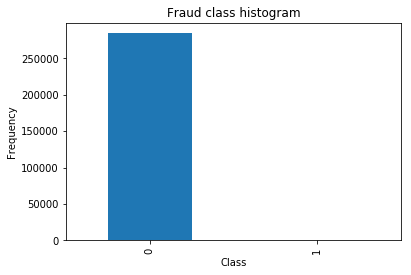

In [107]:
classes = pd.value_counts(data['Class'], sort = True).sort_index()
classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [108]:
data.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

#### The Data is hihgly imbalance. 284315 Normal transaction vs 492 Fraud transaction

## 1. Run with Normalising data

In [109]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [110]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
print('xtrain shape')
print(X_train.shape)
print('xtest shape')
print(X_test.shape)

xtrain shape
(199364, 30)
xtest shape
(85443, 30)


In [111]:
# Normalising the training data and test data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [112]:
# Fit classifier to a model
classifier = RandomForestClassifier()
classifier.fit(X_train_normalized, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [113]:
# Predicting the Test set results
y_pred = classifier.predict(X_test_normalized)

In [114]:
# Making a Confusion Matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm

Confusion Matrix


array([[85296,     5],
       [   36,   106]])

In [115]:
print('Classification Report')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85301
          1       0.95      0.75      0.84       142

avg / total       1.00      1.00      1.00     85443

Accuracy : 0.999520
Area under the curve : 0.873210


## 2. Run with Over Sampling data using SMOTE (Synthetic Minority Over-sampling Technique)

In [116]:
data2 = pd.read_csv("creditcard.csv")

In [117]:
from sklearn.preprocessing import StandardScaler

data2['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data2 = data2.drop(['Time','Amount'],axis=1)
data2.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-0.332040
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,1.646533
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0.156846
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-0.113384
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.291739


In [118]:
X = np.array(data.ix[:, data.columns != 'Class'])
y = np.array(data.ix[:, data.columns == 'Class'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (284807, 30)
Shape of y: (284807, 1)


In [119]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('xtrain shape')
print(X_train.shape)
print('xtest shape')
print(X_test.shape)

xtrain shape
(199364, 30)
xtest shape
(85443, 30)


In [120]:
# Over Sampling data using SMOTE
smote = SMOTE(random_state=2)
X_train_resample, y_train_resample = smote.fit_sample(X_train, y_train.ravel())

In [121]:
classifier = RandomForestClassifier()
classifier.fit(X_train_resample, y_train_resample.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [122]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [123]:
# Making a Confision Matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm

Confusion Matrix


array([[85284,    17],
       [   29,   113]])

In [124]:
print('Classification Report')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85301
          1       0.87      0.80      0.83       142

avg / total       1.00      1.00      1.00     85443

Accuracy : 0.999462
Area under the curve : 0.897788


## 3. Run with Generative Adversarial Networks (GANs)

In [125]:
data = pd.read_csv("creditcard.csv")
data.drop(['Time'], axis = 1, inplace = True)
data.drop(['Class'], axis = 1, inplace = True)

In [126]:
# Convert data frame to a numpy array
data = np.array(data)
data

array([[ -1.35980713e+00,  -7.27811733e-02,   2.53634674e+00, ...,
          1.33558377e-01,  -2.10530535e-02,   1.49620000e+02],
       [  1.19185711e+00,   2.66150712e-01,   1.66480113e-01, ...,
         -8.98309914e-03,   1.47241692e-02,   2.69000000e+00],
       [ -1.35835406e+00,  -1.34016307e+00,   1.77320934e+00, ...,
         -5.53527940e-02,  -5.97518406e-02,   3.78660000e+02],
       ..., 
       [  1.91956501e+00,  -3.01253846e-01,  -3.24963981e+00, ...,
          4.45477214e-03,  -2.65608286e-02,   6.78800000e+01],
       [ -2.40440050e-01,   5.30482513e-01,   7.02510230e-01, ...,
          1.08820735e-01,   1.04532821e-01,   1.00000000e+01],
       [ -5.33412522e-01,  -1.89733337e-01,   7.03337367e-01, ...,
         -2.41530880e-03,   1.36489143e-02,   2.17000000e+02]])

In [127]:
# Convert array to PyTorch tensor
data = torch.FloatTensor(data)
data.size()

torch.Size([284807, 29])

In [128]:
# Generator's paragrams
g_input_size = 1     # Random noise dimension
g_hidden_size = 50   # Generator complexity
g_output_size = 1   
g_learning_rate = 0.0002
g_steps = 1

#Discriminator's paragrams
d_input_size = 29   # Minibatch size
d_hidden_size = 50  # Discriminator complexity
d_output_size = 1   # Single dimension for 'real' vs. 'fake'
d_learning_rate = 0.0002
d_steps = 1 

minibatch_size = d_input_size

optim_betas = (0.5, 0.999)
num_epochs = 10000
print_interval = 100

In [129]:
(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
print("Using data [%s]" % (name))

Using data [Raw data]


In [130]:
def inject_fake_data():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator.


In [131]:
# Generator
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

In [132]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

In [133]:
def extract(v):
    return v.data.storage().tolist()

In [134]:
def stats(d):
    return [np.mean(d), np.std(d)]

In [135]:
def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

In [136]:
d_sampler = data[0]
gi_sampler = inject_fake_data()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)


In [ ]:
# Training GANs
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)


for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Updating the weights of the Discriminator
        D.zero_grad() # Initialize gradients of the Discriminator to 0

        # Training the Discriminator with real data
        input = Variable(d_sampler) # Wrap it in a variable
        output = D(preprocess(input)) # Forward propagate this real data into the neural network
        #target = Variable(torch.ones(input.size()[0]))
        target = Variable(torch.ones(1)) # Get the target
        d_real_error = criterion(output, target) # Compute the loss between the prediction and actual
        d_real_error.backward() # Compute/store gradients
    
        # Train the Discriminator with a fake data generated by the Generator
        #d_gen_input = Variable(gi_sampler(minibatch_size, 29))
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        
        output = D(preprocess(d_fake_data.t()))
        target = Variable(torch.zeros(1))
        d_fake_error = criterion(output, target)  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # # Apply SGD to update the weight
        
    for g_index in range(g_steps):
        # 2. Update the weight of the Generator 
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        output = D(preprocess(g_fake_data.t()))
        target = Variable(torch.ones(1))
        g_error = criterion(output, target)
        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        
    if epoch % print_interval == 0:
        print("%s: Discriminator: Real Error %s / Fake Error %s Generator: %s (Real Data: %s, Fake Data: %s) " % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error)[0],
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))


0: Discriminator: Real Error 0.607317328453064 / Fake Error 0.6823877096176147 Generator: 0.7059551477432251 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.098921421786834454, 0.0064182583676690927]) 
100: Discriminator: Real Error 0.006616138853132725 / Fake Error 0.5579261183738708 Generator: 0.8513996005058289 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [0.022986474222150343, 0.0010658655555912265]) 
200: Discriminator: Real Error 0.0012629254488274455 / Fake Error 0.3857477903366089 Generator: 1.1431217193603516 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.02487429873696689, 0.0036143318495017863]) 
300: Discriminator: Real Error 0.0003931699029635638 / Fake Error 0.20293503999710083 Generator: 1.7141870260238647 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.44161324459930945, 0.01005152403103385]) 
400: Discriminator: Real Error 0.00018461262516211718 / Fake Error 0.13475991785526276 Generato

3600: Discriminator: Real Error 4.76838204122032e-06 / Fake Error 0.0002144565514754504 Generator: 8.546331405639648 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [0.015076383434492966, 2.4055532833261206]) 
3700: Discriminator: Real Error 4.76838204122032e-06 / Fake Error 0.00190460542216897 Generator: 7.700901031494141 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [0.61973457449469072, 2.7600484519978372]) 
3800: Discriminator: Real Error 1.4305215700005647e-05 / Fake Error 9.28994850255549e-05 Generator: 10.751123428344727 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-1.5110679651642669, 2.6909928932018192]) 
3900: Discriminator: Real Error 1.7285496141994372e-05 / Fake Error 0.00048085645539686084 Generator: 7.056056499481201 (Real Data: [3.0465385945408836, 49.174943056117513], Fake Data: [-0.38900126825118886, 2.7220841331541044]) 
4000: Discriminator: Real Error 8.463894118904136e-06 / Fake Error 0.00035131489858031273 G